In [1]:
import numpy as np
import pandas as pd
import joblib

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading our inputs for training**

In [3]:
df_inputs = torch.load('tensors/df_inputs.pt')
df_inputs

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0021, 0.0014,  ..., 0.0008, 0.0012, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

**B. Loading our targets for training**

In [4]:
df_targets = torch.load('tensors/df_targets.pt')
df_targets

tensor([1, 2, 1,  ..., 0, 1, 1])

**C. Loading our inputs for testing**

In [5]:
X_test_vec = torch.load('tensors/X_test_vec.pt')
X_test_vec

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

**D. Loading our targets for testing**

In [6]:
y_test = torch.load('tensors/y_test.pt')
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

**E. Creating our Neural Network Architecture**

In [7]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class BalancedNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 50) # input to first hidden layer, produces 50 features
        self.output_layer = nn.Linear(50, self.out_dim) # takes in 50 features, produces 3 feature (y)
        self.activation = nn.ReLU()  # <- add in ReLU activation function

    def forward(self, x):
        x = self.activation(self.hidden_layer_1(x))
        y = self.output_layer(x)
        
        return y

In [8]:
# Create an instance of the model and send it to target device
model_3 = BalancedNeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_3

BalancedNeuralNetwork(
  (hidden_layer_1): Linear(in_features=5000, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
  (activation): ReLU()
)

In [9]:
learning_rate_3 = 0.0001
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=learning_rate_3)
batch_size = 128

In [10]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

**F. Training the Network**

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
import time
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset_3 = MyCustomDataset(x=df_inputs, y=df_targets)

train_loader = DataLoader(
    custom_dataset_3,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 300
losses_3 = []

start = time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_3,
        optimizer_3,
        loss_fn_3,
        batch_size
    )
    
    losses_3.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

end = time.time()    
print(f'Training duration: {(end-start)} seconds')

state = { 'state_dict': model_3.state_dict() }
torch.save(state, "./torch_models/model_3.pth")

Epoch: 0


100%|██████████| 492/492 [00:16<00:00, 29.35it/s, loss=1.03]


Ave Loss: 1.0767962663638881
Epoch: 1


100%|██████████| 492/492 [00:11<00:00, 41.83it/s, loss=0.913]


Ave Loss: 0.9911179162137876
Epoch: 2


100%|██████████| 492/492 [00:11<00:00, 41.12it/s, loss=0.808]


Ave Loss: 0.8944669623927373
Epoch: 3


100%|██████████| 492/492 [00:11<00:00, 41.31it/s, loss=0.732]


Ave Loss: 0.8195507554261665
Epoch: 4


100%|██████████| 492/492 [00:11<00:00, 41.72it/s, loss=0.675]


Ave Loss: 0.765001576969294
Epoch: 5


100%|██████████| 492/492 [00:11<00:00, 41.90it/s, loss=0.632]


Ave Loss: 0.7241887134022829
Epoch: 6


100%|██████████| 492/492 [00:11<00:00, 41.93it/s, loss=0.597]


Ave Loss: 0.6934388643357812
Epoch: 7


100%|██████████| 492/492 [00:11<00:00, 41.94it/s, loss=0.569]


Ave Loss: 0.6692807789498229
Epoch: 8


100%|██████████| 492/492 [00:11<00:00, 42.06it/s, loss=0.547]


Ave Loss: 0.6499847692202746
Epoch: 9


100%|██████████| 492/492 [00:11<00:00, 41.81it/s, loss=0.528]


Ave Loss: 0.6344870568775549
Epoch: 10


100%|██████████| 492/492 [00:11<00:00, 41.00it/s, loss=0.513]


Ave Loss: 0.621726174725265
Epoch: 11


100%|██████████| 492/492 [00:11<00:00, 41.39it/s, loss=0.5]  


Ave Loss: 0.6110156450450905
Epoch: 12


100%|██████████| 492/492 [00:11<00:00, 41.77it/s, loss=0.49] 


Ave Loss: 0.601865058386229
Epoch: 13


100%|██████████| 492/492 [00:11<00:00, 42.07it/s, loss=0.48] 


Ave Loss: 0.5939185238344883
Epoch: 14


100%|██████████| 492/492 [00:11<00:00, 41.94it/s, loss=0.472]


Ave Loss: 0.5869207613594164
Epoch: 15


100%|██████████| 492/492 [00:11<00:00, 41.31it/s, loss=0.466]


Ave Loss: 0.5806789257056345
Epoch: 16


100%|██████████| 492/492 [00:12<00:00, 37.85it/s, loss=0.46] 


Ave Loss: 0.575042894821826
Epoch: 17


100%|██████████| 492/492 [00:12<00:00, 38.76it/s, loss=0.454]


Ave Loss: 0.5699001096370744
Epoch: 18


100%|██████████| 492/492 [00:12<00:00, 39.61it/s, loss=0.45] 


Ave Loss: 0.5651705215980367
Epoch: 19


100%|██████████| 492/492 [00:11<00:00, 41.88it/s, loss=0.446]


Ave Loss: 0.5607839702227251
Epoch: 20


100%|██████████| 492/492 [00:11<00:00, 42.18it/s, loss=0.442]


Ave Loss: 0.5566870776739546
Epoch: 21


100%|██████████| 492/492 [00:11<00:00, 41.69it/s, loss=0.438]


Ave Loss: 0.5528413014319854
Epoch: 22


100%|██████████| 492/492 [00:11<00:00, 41.31it/s, loss=0.435]


Ave Loss: 0.5492117129932574
Epoch: 23


100%|██████████| 492/492 [00:11<00:00, 41.72it/s, loss=0.432]


Ave Loss: 0.5457708753827142
Epoch: 24


100%|██████████| 492/492 [00:11<00:00, 41.69it/s, loss=0.429]


Ave Loss: 0.5424974672799188
Epoch: 25


100%|██████████| 492/492 [00:11<00:00, 41.57it/s, loss=0.426]


Ave Loss: 0.5393707815830301
Epoch: 26


100%|██████████| 492/492 [00:11<00:00, 41.55it/s, loss=0.424]


Ave Loss: 0.5363774050057419
Epoch: 27


100%|██████████| 492/492 [00:11<00:00, 41.46it/s, loss=0.421]


Ave Loss: 0.5334996190376398
Epoch: 28


100%|██████████| 492/492 [00:11<00:00, 41.45it/s, loss=0.418]


Ave Loss: 0.5307258051948819
Epoch: 29


100%|██████████| 492/492 [00:11<00:00, 41.66it/s, loss=0.416]


Ave Loss: 0.5280470253248525
Epoch: 30


100%|██████████| 492/492 [00:11<00:00, 41.70it/s, loss=0.414]


Ave Loss: 0.5254590995306891
Epoch: 31


100%|██████████| 492/492 [00:11<00:00, 41.71it/s, loss=0.411]


Ave Loss: 0.5229538763320543
Epoch: 32


100%|██████████| 492/492 [00:11<00:00, 42.14it/s, loss=0.409]


Ave Loss: 0.5205226240725052
Epoch: 33


100%|██████████| 492/492 [00:11<00:00, 42.01it/s, loss=0.407]


Ave Loss: 0.5181564360978158
Epoch: 34


100%|██████████| 492/492 [00:11<00:00, 41.72it/s, loss=0.405]


Ave Loss: 0.5158573169170356
Epoch: 35


100%|██████████| 492/492 [00:11<00:00, 41.64it/s, loss=0.403]


Ave Loss: 0.513613587109054
Epoch: 36


100%|██████████| 492/492 [00:11<00:00, 41.72it/s, loss=0.4]  


Ave Loss: 0.5114312343359962
Epoch: 37


100%|██████████| 492/492 [00:11<00:00, 41.69it/s, loss=0.398]


Ave Loss: 0.509299030875772
Epoch: 38


100%|██████████| 492/492 [00:11<00:00, 41.41it/s, loss=0.396]


Ave Loss: 0.5072166192216602
Epoch: 39


100%|██████████| 492/492 [00:11<00:00, 41.36it/s, loss=0.394]


Ave Loss: 0.5051790591541344
Epoch: 40


100%|██████████| 492/492 [00:12<00:00, 40.96it/s, loss=0.392]


Ave Loss: 0.5031805845295511
Epoch: 41


100%|██████████| 492/492 [00:11<00:00, 41.36it/s, loss=0.39] 


Ave Loss: 0.5012215205687818
Epoch: 42


100%|██████████| 492/492 [00:11<00:00, 41.10it/s, loss=0.388]


Ave Loss: 0.49929657941911276
Epoch: 43


100%|██████████| 492/492 [00:11<00:00, 41.85it/s, loss=0.386]


Ave Loss: 0.4974044488697517
Epoch: 44


100%|██████████| 492/492 [00:11<00:00, 41.43it/s, loss=0.384]


Ave Loss: 0.4955441644642411
Epoch: 45


100%|██████████| 492/492 [00:11<00:00, 41.26it/s, loss=0.382]


Ave Loss: 0.4937188745271869
Epoch: 46


100%|██████████| 492/492 [00:11<00:00, 41.40it/s, loss=0.38] 


Ave Loss: 0.4919228137629788
Epoch: 47


100%|██████████| 492/492 [00:11<00:00, 42.10it/s, loss=0.378]


Ave Loss: 0.4901540128559601
Epoch: 48


100%|██████████| 492/492 [00:11<00:00, 41.88it/s, loss=0.377]


Ave Loss: 0.48841407543760007
Epoch: 49


100%|██████████| 492/492 [00:11<00:00, 41.54it/s, loss=0.375]


Ave Loss: 0.4867016709432369
Epoch: 50


100%|██████████| 492/492 [00:11<00:00, 41.70it/s, loss=0.373]


Ave Loss: 0.4850120487494197
Epoch: 51


100%|██████████| 492/492 [00:12<00:00, 40.28it/s, loss=0.371]


Ave Loss: 0.4833452412631454
Epoch: 52


100%|██████████| 492/492 [00:12<00:00, 38.84it/s, loss=0.369]


Ave Loss: 0.4816940478314229
Epoch: 53


100%|██████████| 492/492 [00:12<00:00, 39.25it/s, loss=0.367]


Ave Loss: 0.4800662155437276
Epoch: 54


100%|██████████| 492/492 [00:12<00:00, 39.29it/s, loss=0.365]


Ave Loss: 0.47845251949095147
Epoch: 55


100%|██████████| 492/492 [00:12<00:00, 40.06it/s, loss=0.363]


Ave Loss: 0.47685456893792966
Epoch: 56


100%|██████████| 492/492 [00:12<00:00, 39.27it/s, loss=0.362]


Ave Loss: 0.4752746041470427
Epoch: 57


100%|██████████| 492/492 [00:12<00:00, 39.94it/s, loss=0.36] 


Ave Loss: 0.47370510215197154
Epoch: 58


100%|██████████| 492/492 [00:12<00:00, 40.01it/s, loss=0.358]


Ave Loss: 0.4721498368837969
Epoch: 59


100%|██████████| 492/492 [00:12<00:00, 39.82it/s, loss=0.356]


Ave Loss: 0.4706135812571378
Epoch: 60


100%|██████████| 492/492 [00:12<00:00, 40.08it/s, loss=0.354]


Ave Loss: 0.4690839697917302
Epoch: 61


100%|██████████| 492/492 [00:12<00:00, 39.79it/s, loss=0.352]


Ave Loss: 0.46757246402463293
Epoch: 62


100%|██████████| 492/492 [00:12<00:00, 39.84it/s, loss=0.35] 


Ave Loss: 0.46607015191054924
Epoch: 63


100%|██████████| 492/492 [00:12<00:00, 40.10it/s, loss=0.349]


Ave Loss: 0.46458153232810945
Epoch: 64


100%|██████████| 492/492 [00:12<00:00, 40.11it/s, loss=0.347]


Ave Loss: 0.46309656643770575
Epoch: 65


100%|██████████| 492/492 [00:12<00:00, 39.95it/s, loss=0.346]


Ave Loss: 0.4616245832142791
Epoch: 66


100%|██████████| 492/492 [00:12<00:00, 39.89it/s, loss=0.344]


Ave Loss: 0.4601589745380045
Epoch: 67


100%|██████████| 492/492 [00:12<00:00, 40.07it/s, loss=0.342]


Ave Loss: 0.4587047316315698
Epoch: 68


100%|██████████| 492/492 [00:12<00:00, 39.85it/s, loss=0.34] 


Ave Loss: 0.45725569771072727
Epoch: 69


100%|██████████| 492/492 [00:12<00:00, 39.84it/s, loss=0.339]


Ave Loss: 0.4558142684097212
Epoch: 70


100%|██████████| 492/492 [00:12<00:00, 39.99it/s, loss=0.337]


Ave Loss: 0.4543810500725498
Epoch: 71


100%|██████████| 492/492 [00:12<00:00, 40.23it/s, loss=0.336]


Ave Loss: 0.45295541364003006
Epoch: 72


100%|██████████| 492/492 [00:12<00:00, 39.95it/s, loss=0.334]


Ave Loss: 0.45153306115691255
Epoch: 73


100%|██████████| 492/492 [00:12<00:00, 39.62it/s, loss=0.332]


Ave Loss: 0.4501236045384795
Epoch: 74


100%|██████████| 492/492 [00:12<00:00, 39.97it/s, loss=0.331]


Ave Loss: 0.4487124511866066
Epoch: 75


100%|██████████| 492/492 [00:12<00:00, 39.85it/s, loss=0.329]


Ave Loss: 0.4473080016006299
Epoch: 76


100%|██████████| 492/492 [00:12<00:00, 40.32it/s, loss=0.327]


Ave Loss: 0.4459119720793352
Epoch: 77


100%|██████████| 492/492 [00:12<00:00, 39.90it/s, loss=0.326]


Ave Loss: 0.4445172757879505
Epoch: 78


100%|██████████| 492/492 [00:12<00:00, 39.93it/s, loss=0.324]


Ave Loss: 0.4431247167834422
Epoch: 79


100%|██████████| 492/492 [00:12<00:00, 39.99it/s, loss=0.323]


Ave Loss: 0.44173958376655736
Epoch: 80


100%|██████████| 492/492 [00:12<00:00, 39.85it/s, loss=0.321]


Ave Loss: 0.44035232297288696
Epoch: 81


100%|██████████| 492/492 [00:12<00:00, 40.02it/s, loss=0.32] 


Ave Loss: 0.43897254032090427
Epoch: 82


100%|██████████| 492/492 [00:12<00:00, 39.94it/s, loss=0.318]


Ave Loss: 0.437590527219501
Epoch: 83


100%|██████████| 492/492 [00:12<00:00, 39.87it/s, loss=0.316]


Ave Loss: 0.4362127594952661
Epoch: 84


100%|██████████| 492/492 [00:12<00:00, 39.95it/s, loss=0.315]


Ave Loss: 0.434834779156902
Epoch: 85


100%|██████████| 492/492 [00:12<00:00, 38.60it/s, loss=0.313]


Ave Loss: 0.4334563662002726
Epoch: 86


100%|██████████| 492/492 [00:12<00:00, 38.75it/s, loss=0.311]


Ave Loss: 0.43207960987721034
Epoch: 87


100%|██████████| 492/492 [00:12<00:00, 38.61it/s, loss=0.31] 


Ave Loss: 0.4307114839917276
Epoch: 88


100%|██████████| 492/492 [00:12<00:00, 39.79it/s, loss=0.308]


Ave Loss: 0.42933957387761373
Epoch: 89


100%|██████████| 492/492 [00:12<00:00, 39.92it/s, loss=0.307]


Ave Loss: 0.42796835018609597
Epoch: 90


100%|██████████| 492/492 [00:12<00:00, 39.66it/s, loss=0.305]


Ave Loss: 0.4265957955058997
Epoch: 91


100%|██████████| 492/492 [00:12<00:00, 39.71it/s, loss=0.304]


Ave Loss: 0.4252277300125215
Epoch: 92


100%|██████████| 492/492 [00:12<00:00, 39.77it/s, loss=0.302]


Ave Loss: 0.4238555437423349
Epoch: 93


100%|██████████| 492/492 [00:12<00:00, 39.87it/s, loss=0.301]


Ave Loss: 0.42248130359543046
Epoch: 94


100%|██████████| 492/492 [00:12<00:00, 39.85it/s, loss=0.299]


Ave Loss: 0.42111226104623906
Epoch: 95


100%|██████████| 492/492 [00:12<00:00, 39.85it/s, loss=0.298]


Ave Loss: 0.41974284275760493
Epoch: 96


100%|██████████| 492/492 [00:12<00:00, 39.94it/s, loss=0.296]


Ave Loss: 0.4183678651243691
Epoch: 97


100%|██████████| 492/492 [00:12<00:00, 39.66it/s, loss=0.295]


Ave Loss: 0.41699588510805996
Epoch: 98


100%|██████████| 492/492 [00:12<00:00, 39.91it/s, loss=0.293]


Ave Loss: 0.4156194550961983
Epoch: 99


100%|██████████| 492/492 [00:12<00:00, 39.83it/s, loss=0.291]


Ave Loss: 0.41425006067365167
Epoch: 100


100%|██████████| 492/492 [00:12<00:00, 39.83it/s, loss=0.29] 


Ave Loss: 0.4128793736662322
Epoch: 101


100%|██████████| 492/492 [00:12<00:00, 39.68it/s, loss=0.288]


Ave Loss: 0.41150059968959996
Epoch: 102


100%|██████████| 492/492 [00:12<00:00, 39.91it/s, loss=0.287]


Ave Loss: 0.4101326397158266
Epoch: 103


100%|██████████| 492/492 [00:12<00:00, 39.89it/s, loss=0.285]


Ave Loss: 0.40875636253172787
Epoch: 104


100%|██████████| 492/492 [00:12<00:00, 39.54it/s, loss=0.284]


Ave Loss: 0.40737794436574953
Epoch: 105


100%|██████████| 492/492 [00:12<00:00, 39.74it/s, loss=0.282]


Ave Loss: 0.4060004593395605
Epoch: 106


100%|██████████| 492/492 [00:12<00:00, 39.72it/s, loss=0.281]


Ave Loss: 0.40462167827579065
Epoch: 107


100%|██████████| 492/492 [00:12<00:00, 39.60it/s, loss=0.279]


Ave Loss: 0.4032391900332963
Epoch: 108


100%|██████████| 492/492 [00:12<00:00, 39.60it/s, loss=0.278]


Ave Loss: 0.4018564304200614
Epoch: 109


100%|██████████| 492/492 [00:12<00:00, 40.09it/s, loss=0.276]


Ave Loss: 0.4004770455563941
Epoch: 110


100%|██████████| 492/492 [00:13<00:00, 37.77it/s, loss=0.275]


Ave Loss: 0.3990872553208979
Epoch: 111


100%|██████████| 492/492 [00:12<00:00, 38.74it/s, loss=0.273]


Ave Loss: 0.39770084667981154
Epoch: 112


100%|██████████| 492/492 [00:12<00:00, 39.38it/s, loss=0.272]


Ave Loss: 0.3963182485563968
Epoch: 113


100%|██████████| 492/492 [00:12<00:00, 39.49it/s, loss=0.271]


Ave Loss: 0.3949222568331695
Epoch: 114


100%|██████████| 492/492 [00:12<00:00, 39.87it/s, loss=0.269]


Ave Loss: 0.3935318807276284
Epoch: 115


100%|██████████| 492/492 [00:12<00:00, 39.71it/s, loss=0.268]


Ave Loss: 0.39214058971501947
Epoch: 116


100%|██████████| 492/492 [00:12<00:00, 39.92it/s, loss=0.266]


Ave Loss: 0.3907515882718854
Epoch: 117


100%|██████████| 492/492 [00:12<00:00, 39.98it/s, loss=0.265]


Ave Loss: 0.38935618890010243
Epoch: 118


100%|██████████| 492/492 [00:12<00:00, 39.87it/s, loss=0.264]


Ave Loss: 0.38795773769781844
Epoch: 119


100%|██████████| 492/492 [00:12<00:00, 39.97it/s, loss=0.262]


Ave Loss: 0.38656073669350244
Epoch: 120


100%|██████████| 492/492 [00:12<00:00, 39.79it/s, loss=0.261]


Ave Loss: 0.38516780073807494
Epoch: 121


100%|██████████| 492/492 [00:12<00:00, 39.93it/s, loss=0.26] 


Ave Loss: 0.38376590282451817
Epoch: 122


100%|██████████| 492/492 [00:12<00:00, 39.97it/s, loss=0.258]


Ave Loss: 0.3823687151316705
Epoch: 123


100%|██████████| 492/492 [00:12<00:00, 39.74it/s, loss=0.257]


Ave Loss: 0.380964225809264
Epoch: 124


100%|██████████| 492/492 [00:12<00:00, 40.02it/s, loss=0.256]


Ave Loss: 0.3795645545895507
Epoch: 125


100%|██████████| 492/492 [00:12<00:00, 39.69it/s, loss=0.254]


Ave Loss: 0.37815870956434466
Epoch: 126


100%|██████████| 492/492 [00:12<00:00, 39.84it/s, loss=0.253]


Ave Loss: 0.37676017265009687
Epoch: 127


100%|██████████| 492/492 [00:12<00:00, 39.86it/s, loss=0.252]


Ave Loss: 0.37534961661672206
Epoch: 128


100%|██████████| 492/492 [00:12<00:00, 39.94it/s, loss=0.251]


Ave Loss: 0.3739429678979928
Epoch: 129


100%|██████████| 492/492 [00:12<00:00, 39.76it/s, loss=0.249]


Ave Loss: 0.37252871761840534
Epoch: 130


100%|██████████| 492/492 [00:12<00:00, 39.86it/s, loss=0.248]


Ave Loss: 0.37111760164058305
Epoch: 131


100%|██████████| 492/492 [00:12<00:00, 39.91it/s, loss=0.247]


Ave Loss: 0.36971051679030664
Epoch: 132


100%|██████████| 492/492 [00:12<00:00, 39.92it/s, loss=0.245]


Ave Loss: 0.36829402739924144
Epoch: 133


100%|██████████| 492/492 [00:12<00:00, 39.67it/s, loss=0.244]


Ave Loss: 0.3668780618506234
Epoch: 134


100%|██████████| 492/492 [00:11<00:00, 41.15it/s, loss=0.243]


Ave Loss: 0.365468439290194
Epoch: 135


100%|██████████| 492/492 [00:12<00:00, 38.98it/s, loss=0.242]


Ave Loss: 0.36404929809817455
Epoch: 136


100%|██████████| 492/492 [00:12<00:00, 38.79it/s, loss=0.241]


Ave Loss: 0.3626386241578474
Epoch: 137


100%|██████████| 492/492 [00:12<00:00, 38.87it/s, loss=0.239]


Ave Loss: 0.36121537412206334
Epoch: 138


100%|██████████| 492/492 [00:12<00:00, 38.84it/s, loss=0.238]


Ave Loss: 0.35980006171072404
Epoch: 139


100%|██████████| 492/492 [00:12<00:00, 39.63it/s, loss=0.237]


Ave Loss: 0.35837915648774404
Epoch: 140


100%|██████████| 492/492 [00:12<00:00, 39.34it/s, loss=0.236]


Ave Loss: 0.3569635060138819
Epoch: 141


100%|██████████| 492/492 [00:12<00:00, 39.57it/s, loss=0.234]


Ave Loss: 0.35554690268344996
Epoch: 142


100%|██████████| 492/492 [00:12<00:00, 39.81it/s, loss=0.233]


Ave Loss: 0.35412313107673715
Epoch: 143


100%|██████████| 492/492 [00:12<00:00, 39.54it/s, loss=0.232]


Ave Loss: 0.3527049063969918
Epoch: 144


100%|██████████| 492/492 [00:12<00:00, 39.58it/s, loss=0.23] 


Ave Loss: 0.35128265225548083
Epoch: 145


100%|██████████| 492/492 [00:12<00:00, 39.79it/s, loss=0.229]


Ave Loss: 0.3498593443111191
Epoch: 146


100%|██████████| 492/492 [00:12<00:00, 39.51it/s, loss=0.228]


Ave Loss: 0.34843588135833664
Epoch: 147


100%|██████████| 492/492 [00:12<00:00, 39.41it/s, loss=0.227]


Ave Loss: 0.3470122154832371
Epoch: 148


100%|██████████| 492/492 [00:12<00:00, 39.62it/s, loss=0.225]


Ave Loss: 0.3455884613520731
Epoch: 149


100%|██████████| 492/492 [00:12<00:00, 39.67it/s, loss=0.224]


Ave Loss: 0.3441669255252776
Epoch: 150


100%|██████████| 492/492 [00:12<00:00, 39.53it/s, loss=0.223]


Ave Loss: 0.342741608589403
Epoch: 151


100%|██████████| 492/492 [00:12<00:00, 39.58it/s, loss=0.222]


Ave Loss: 0.34131687788701637
Epoch: 152


100%|██████████| 492/492 [00:12<00:00, 39.70it/s, loss=0.221]


Ave Loss: 0.33988456128210554
Epoch: 153


100%|██████████| 492/492 [00:12<00:00, 39.69it/s, loss=0.219]


Ave Loss: 0.33845684801538783
Epoch: 154


100%|██████████| 492/492 [00:12<00:00, 38.43it/s, loss=0.218]


Ave Loss: 0.33702862738230366
Epoch: 155


100%|██████████| 492/492 [00:12<00:00, 39.98it/s, loss=0.217]


Ave Loss: 0.33559526484913943
Epoch: 156


100%|██████████| 492/492 [00:12<00:00, 38.19it/s, loss=0.216]


Ave Loss: 0.33416456020459895
Epoch: 157


100%|██████████| 492/492 [00:12<00:00, 38.64it/s, loss=0.215]


Ave Loss: 0.3327330497161644
Epoch: 158


100%|██████████| 492/492 [00:12<00:00, 38.93it/s, loss=0.213]


Ave Loss: 0.33129940082023784
Epoch: 159


100%|██████████| 492/492 [00:12<00:00, 38.40it/s, loss=0.212]


Ave Loss: 0.32986791334985716
Epoch: 160


100%|██████████| 492/492 [00:12<00:00, 39.50it/s, loss=0.211]


Ave Loss: 0.32843719707514213
Epoch: 161


100%|██████████| 492/492 [00:12<00:00, 39.58it/s, loss=0.21] 


Ave Loss: 0.32700247520474884
Epoch: 162


100%|██████████| 492/492 [00:12<00:00, 39.72it/s, loss=0.209]


Ave Loss: 0.3255787844035199
Epoch: 163


100%|██████████| 492/492 [00:12<00:00, 39.60it/s, loss=0.208]


Ave Loss: 0.3241444047752435
Epoch: 164


100%|██████████| 492/492 [00:12<00:00, 39.69it/s, loss=0.207]


Ave Loss: 0.32271391834791113
Epoch: 165


100%|██████████| 492/492 [00:12<00:00, 39.84it/s, loss=0.206]


Ave Loss: 0.3212880233257282
Epoch: 166


100%|██████████| 492/492 [00:12<00:00, 39.83it/s, loss=0.204]


Ave Loss: 0.3198600843609349
Epoch: 167


100%|██████████| 492/492 [00:12<00:00, 39.74it/s, loss=0.204]


Ave Loss: 0.31843208903219644
Epoch: 168


100%|██████████| 492/492 [00:12<00:00, 39.80it/s, loss=0.203]


Ave Loss: 0.3170060183156312
Epoch: 169


100%|██████████| 492/492 [00:12<00:00, 39.84it/s, loss=0.201]


Ave Loss: 0.3155869089551573
Epoch: 170


100%|██████████| 492/492 [00:12<00:00, 39.47it/s, loss=0.2]  


Ave Loss: 0.3141483621808087
Epoch: 171


100%|██████████| 492/492 [00:12<00:00, 39.41it/s, loss=0.199]


Ave Loss: 0.3127263343431116
Epoch: 172


100%|██████████| 492/492 [00:12<00:00, 39.74it/s, loss=0.198]


Ave Loss: 0.3112967938972198
Epoch: 173


100%|██████████| 492/492 [00:12<00:00, 39.39it/s, loss=0.197]


Ave Loss: 0.30987034913727907
Epoch: 174


100%|██████████| 492/492 [00:12<00:00, 38.95it/s, loss=0.196]


Ave Loss: 0.30844461236421655
Epoch: 175


100%|██████████| 492/492 [00:12<00:00, 38.57it/s, loss=0.194]


Ave Loss: 0.3070207840301157
Epoch: 176


100%|██████████| 492/492 [00:12<00:00, 38.57it/s, loss=0.193]


Ave Loss: 0.3055950185147727
Epoch: 177


100%|██████████| 492/492 [00:12<00:00, 38.46it/s, loss=0.192]


Ave Loss: 0.30416576964099235
Epoch: 178


100%|██████████| 492/492 [00:12<00:00, 38.13it/s, loss=0.191]


Ave Loss: 0.30274509835412833
Epoch: 179


100%|██████████| 492/492 [00:12<00:00, 39.13it/s, loss=0.19] 


Ave Loss: 0.30131465478277786
Epoch: 180


100%|██████████| 492/492 [00:12<00:00, 38.96it/s, loss=0.189]


Ave Loss: 0.2998982368082535
Epoch: 181


100%|██████████| 492/492 [00:12<00:00, 39.20it/s, loss=0.188]


Ave Loss: 0.2984701802999508
Epoch: 182


100%|██████████| 492/492 [00:12<00:00, 39.44it/s, loss=0.187]


Ave Loss: 0.29704824832033333
Epoch: 183


100%|██████████| 492/492 [00:12<00:00, 39.23it/s, loss=0.185]


Ave Loss: 0.2956290812632902
Epoch: 184


100%|██████████| 492/492 [00:12<00:00, 38.99it/s, loss=0.184]


Ave Loss: 0.29421352034782977
Epoch: 185


100%|██████████| 492/492 [00:12<00:00, 39.42it/s, loss=0.183]


Ave Loss: 0.29278445043941825
Epoch: 186


100%|██████████| 492/492 [00:12<00:00, 39.38it/s, loss=0.182]


Ave Loss: 0.291376567680419
Epoch: 187


100%|██████████| 492/492 [00:12<00:00, 38.88it/s, loss=0.181]


Ave Loss: 0.2899523953172734
Epoch: 188


100%|██████████| 492/492 [00:12<00:00, 39.45it/s, loss=0.18] 


Ave Loss: 0.28854297501284903
Epoch: 189


100%|██████████| 492/492 [00:12<00:00, 39.55it/s, loss=0.179]


Ave Loss: 0.28713211608005734
Epoch: 190


100%|██████████| 492/492 [00:12<00:00, 39.21it/s, loss=0.178]


Ave Loss: 0.2857212018433625
Epoch: 191


100%|██████████| 492/492 [00:12<00:00, 39.07it/s, loss=0.176]


Ave Loss: 0.2843117894438224
Epoch: 192


100%|██████████| 492/492 [00:12<00:00, 38.91it/s, loss=0.175]


Ave Loss: 0.2829006083188503
Epoch: 193


100%|██████████| 492/492 [00:12<00:00, 39.42it/s, loss=0.174]


Ave Loss: 0.2814968953711715
Epoch: 194


100%|██████████| 492/492 [00:12<00:00, 39.04it/s, loss=0.173]


Ave Loss: 0.2800997935417222
Epoch: 195


100%|██████████| 492/492 [00:12<00:00, 39.10it/s, loss=0.172]


Ave Loss: 0.2786872589248952
Epoch: 196


100%|██████████| 492/492 [00:12<00:00, 39.57it/s, loss=0.171]


Ave Loss: 0.27728877198405383
Epoch: 197


100%|██████████| 492/492 [00:12<00:00, 39.10it/s, loss=0.17] 


Ave Loss: 0.2758945066451542
Epoch: 198


100%|██████████| 492/492 [00:12<00:00, 40.23it/s, loss=0.169]


Ave Loss: 0.274494684293745
Epoch: 199


100%|██████████| 492/492 [00:11<00:00, 42.25it/s, loss=0.167]


Ave Loss: 0.27309742582038166
Epoch: 200


100%|██████████| 492/492 [00:12<00:00, 39.74it/s, loss=0.167]


Ave Loss: 0.2717074838171645
Epoch: 201


100%|██████████| 492/492 [00:12<00:00, 39.75it/s, loss=0.165]


Ave Loss: 0.270314304173235
Epoch: 202


100%|██████████| 492/492 [00:12<00:00, 39.87it/s, loss=0.164]


Ave Loss: 0.2689217568291881
Epoch: 203


100%|██████████| 492/492 [00:12<00:00, 39.68it/s, loss=0.164]


Ave Loss: 0.26753722309945077
Epoch: 204


100%|██████████| 492/492 [00:12<00:00, 39.71it/s, loss=0.163]


Ave Loss: 0.2661517911810216
Epoch: 205


100%|██████████| 492/492 [00:12<00:00, 39.63it/s, loss=0.161]


Ave Loss: 0.264769951532769
Epoch: 206


100%|██████████| 492/492 [00:12<00:00, 39.83it/s, loss=0.161]


Ave Loss: 0.26339452780359157
Epoch: 207


100%|██████████| 492/492 [00:13<00:00, 36.69it/s, loss=0.159]


Ave Loss: 0.26201012936549456
Epoch: 208


100%|██████████| 492/492 [00:12<00:00, 38.31it/s, loss=0.159]


Ave Loss: 0.26063892230149205
Epoch: 209


100%|██████████| 492/492 [00:12<00:00, 38.40it/s, loss=0.158]


Ave Loss: 0.2592688370041731
Epoch: 210


100%|██████████| 492/492 [00:12<00:00, 39.02it/s, loss=0.157]


Ave Loss: 0.25789717699938675
Epoch: 211


100%|██████████| 492/492 [00:12<00:00, 39.24it/s, loss=0.156]


Ave Loss: 0.25653626751608966
Epoch: 212


100%|██████████| 492/492 [00:12<00:00, 39.47it/s, loss=0.155]


Ave Loss: 0.25518043863216067
Epoch: 213


100%|██████████| 492/492 [00:12<00:00, 38.94it/s, loss=0.154]


Ave Loss: 0.25381580322253994
Epoch: 214


100%|██████████| 492/492 [00:12<00:00, 39.49it/s, loss=0.153]


Ave Loss: 0.2524698045922489
Epoch: 215


100%|██████████| 492/492 [00:12<00:00, 39.38it/s, loss=0.152]


Ave Loss: 0.25112135665930385
Epoch: 216


100%|██████████| 492/492 [00:12<00:00, 39.14it/s, loss=0.151]


Ave Loss: 0.2497706047706003
Epoch: 217


100%|██████████| 492/492 [00:12<00:00, 39.46it/s, loss=0.15] 


Ave Loss: 0.24842922026064337
Epoch: 218


100%|██████████| 492/492 [00:12<00:00, 39.39it/s, loss=0.15] 


Ave Loss: 0.24708135959094132
Epoch: 219


100%|██████████| 492/492 [00:12<00:00, 39.28it/s, loss=0.149]


Ave Loss: 0.2457424643623635
Epoch: 220


100%|██████████| 492/492 [00:12<00:00, 39.32it/s, loss=0.148]


Ave Loss: 0.24440912205756196
Epoch: 221


100%|██████████| 492/492 [00:12<00:00, 39.31it/s, loss=0.147]


Ave Loss: 0.24307749371945372
Epoch: 222


100%|██████████| 492/492 [00:12<00:00, 39.34it/s, loss=0.146]


Ave Loss: 0.24174799555079723
Epoch: 223


100%|██████████| 492/492 [00:12<00:00, 39.34it/s, loss=0.145]


Ave Loss: 0.24041967660309824
Epoch: 224


100%|██████████| 492/492 [00:12<00:00, 39.40it/s, loss=0.144]


Ave Loss: 0.23910116101425838
Epoch: 225


100%|██████████| 492/492 [00:12<00:00, 39.50it/s, loss=0.143]


Ave Loss: 0.23778570388875356
Epoch: 226


100%|██████████| 492/492 [00:12<00:00, 39.22it/s, loss=0.143]


Ave Loss: 0.23646882397493696
Epoch: 227


100%|██████████| 492/492 [00:12<00:00, 39.10it/s, loss=0.142]


Ave Loss: 0.23515794447403612
Epoch: 228


100%|██████████| 492/492 [00:12<00:00, 39.35it/s, loss=0.141]


Ave Loss: 0.23385336958780523
Epoch: 229


100%|██████████| 492/492 [00:12<00:00, 39.38it/s, loss=0.14] 


Ave Loss: 0.23254834333570992
Epoch: 230


100%|██████████| 492/492 [00:12<00:00, 39.18it/s, loss=0.139]


Ave Loss: 0.23126096054305875
Epoch: 231


100%|██████████| 492/492 [00:12<00:00, 40.67it/s, loss=0.138]


Ave Loss: 0.22996257233425854
Epoch: 232


100%|██████████| 492/492 [00:11<00:00, 41.93it/s, loss=0.137]


Ave Loss: 0.22867346679170927
Epoch: 233


100%|██████████| 492/492 [00:12<00:00, 39.71it/s, loss=0.137]


Ave Loss: 0.22738306278862605
Epoch: 234


100%|██████████| 492/492 [00:12<00:00, 39.98it/s, loss=0.136]


Ave Loss: 0.22610305643420878
Epoch: 235


100%|██████████| 492/492 [00:12<00:00, 39.80it/s, loss=0.135]


Ave Loss: 0.22482805568876305
Epoch: 236


100%|██████████| 492/492 [00:12<00:00, 39.56it/s, loss=0.134]


Ave Loss: 0.22355436073328422
Epoch: 237


100%|██████████| 492/492 [00:12<00:00, 39.91it/s, loss=0.133]


Ave Loss: 0.22228448683532273
Epoch: 238


100%|██████████| 492/492 [00:12<00:00, 39.83it/s, loss=0.132]


Ave Loss: 0.2210148025334366
Epoch: 239


100%|██████████| 492/492 [00:12<00:00, 39.72it/s, loss=0.132]


Ave Loss: 0.219754736264789
Epoch: 240


100%|██████████| 492/492 [00:12<00:00, 39.75it/s, loss=0.131]


Ave Loss: 0.21850155551380257
Epoch: 241


100%|██████████| 492/492 [00:12<00:00, 39.53it/s, loss=0.13] 


Ave Loss: 0.21724423517783484
Epoch: 242


100%|██████████| 492/492 [00:12<00:00, 39.99it/s, loss=0.129]


Ave Loss: 0.2159992185065417
Epoch: 243


100%|██████████| 492/492 [00:12<00:00, 39.58it/s, loss=0.128]


Ave Loss: 0.2147494746841551
Epoch: 244


100%|██████████| 492/492 [00:12<00:00, 39.51it/s, loss=0.127]


Ave Loss: 0.21351273960577763
Epoch: 245


100%|██████████| 492/492 [00:12<00:00, 39.72it/s, loss=0.126]


Ave Loss: 0.21228051433960596
Epoch: 246


100%|██████████| 492/492 [00:12<00:00, 39.71it/s, loss=0.126]


Ave Loss: 0.21104337845936538
Epoch: 247


100%|██████████| 492/492 [00:12<00:00, 39.59it/s, loss=0.125]


Ave Loss: 0.20981477034406934
Epoch: 248


100%|██████████| 492/492 [00:12<00:00, 39.62it/s, loss=0.124]


Ave Loss: 0.20859345204643603
Epoch: 249


100%|██████████| 492/492 [00:12<00:00, 39.49it/s, loss=0.123]


Ave Loss: 0.2073713036602348
Epoch: 250


100%|██████████| 492/492 [00:12<00:00, 40.33it/s, loss=0.122]


Ave Loss: 0.20615085352181903
Epoch: 251


100%|██████████| 492/492 [00:12<00:00, 40.19it/s, loss=0.122]


Ave Loss: 0.20494051444215503
Epoch: 252


100%|██████████| 492/492 [00:12<00:00, 40.43it/s, loss=0.121]


Ave Loss: 0.20373794366794873
Epoch: 253


100%|██████████| 492/492 [00:12<00:00, 40.51it/s, loss=0.12] 


Ave Loss: 0.20253087654406945
Epoch: 254


100%|██████████| 492/492 [00:12<00:00, 40.44it/s, loss=0.119]


Ave Loss: 0.20133573042486258
Epoch: 255


100%|██████████| 492/492 [00:12<00:00, 40.54it/s, loss=0.118]


Ave Loss: 0.20013505209812787
Epoch: 256


100%|██████████| 492/492 [00:12<00:00, 40.34it/s, loss=0.118]


Ave Loss: 0.1989429216317045
Epoch: 257


100%|██████████| 492/492 [00:12<00:00, 40.70it/s, loss=0.117]


Ave Loss: 0.1977655887149456
Epoch: 258


100%|██████████| 492/492 [00:12<00:00, 40.59it/s, loss=0.116]


Ave Loss: 0.19658126020274028
Epoch: 259


100%|██████████| 492/492 [00:12<00:00, 40.70it/s, loss=0.115]


Ave Loss: 0.19540434442763407
Epoch: 260


100%|██████████| 492/492 [00:12<00:00, 40.63it/s, loss=0.115]


Ave Loss: 0.19423355713365523
Epoch: 261


100%|██████████| 492/492 [00:12<00:00, 40.27it/s, loss=0.114]


Ave Loss: 0.19306219528179344
Epoch: 262


100%|██████████| 492/492 [00:12<00:00, 40.59it/s, loss=0.113]


Ave Loss: 0.19189934337102785
Epoch: 263


100%|██████████| 492/492 [00:12<00:00, 40.44it/s, loss=0.112]


Ave Loss: 0.19074071392538103
Epoch: 264


100%|██████████| 492/492 [00:12<00:00, 40.20it/s, loss=0.111]


Ave Loss: 0.1895869488608304
Epoch: 265


100%|██████████| 492/492 [00:12<00:00, 40.62it/s, loss=0.111]


Ave Loss: 0.1884354020400745
Epoch: 266


100%|██████████| 492/492 [00:12<00:00, 40.36it/s, loss=0.11] 


Ave Loss: 0.18729319143283174
Epoch: 267


100%|██████████| 492/492 [00:12<00:00, 40.46it/s, loss=0.109]


Ave Loss: 0.1861457663580654
Epoch: 268


100%|██████████| 492/492 [00:12<00:00, 40.49it/s, loss=0.108]


Ave Loss: 0.1850160736499763
Epoch: 269


100%|██████████| 492/492 [00:12<00:00, 40.43it/s, loss=0.108]


Ave Loss: 0.18389123572203203
Epoch: 270


100%|██████████| 492/492 [00:12<00:00, 40.32it/s, loss=0.107]


Ave Loss: 0.18276594027998003
Epoch: 271


100%|██████████| 492/492 [00:12<00:00, 40.54it/s, loss=0.106]


Ave Loss: 0.1816435097376021
Epoch: 272


100%|██████████| 492/492 [00:12<00:00, 40.28it/s, loss=0.105]


Ave Loss: 0.1805268507753688
Epoch: 273


100%|██████████| 492/492 [00:12<00:00, 40.48it/s, loss=0.105]


Ave Loss: 0.17942128656053447
Epoch: 274


100%|██████████| 492/492 [00:12<00:00, 40.52it/s, loss=0.104] 


Ave Loss: 0.17831027860624518
Epoch: 275


100%|██████████| 492/492 [00:12<00:00, 40.57it/s, loss=0.103] 


Ave Loss: 0.17721049881320658
Epoch: 276


100%|██████████| 492/492 [00:12<00:00, 40.37it/s, loss=0.102] 


Ave Loss: 0.1761034423470255
Epoch: 277


100%|██████████| 492/492 [00:12<00:00, 40.43it/s, loss=0.101]


Ave Loss: 0.1750202571322036
Epoch: 278


100%|██████████| 492/492 [00:12<00:00, 40.10it/s, loss=0.101] 


Ave Loss: 0.17392498727251843
Epoch: 279


100%|██████████| 492/492 [00:12<00:00, 40.51it/s, loss=0.1]   


Ave Loss: 0.17283551063297725
Epoch: 280


100%|██████████| 492/492 [00:12<00:00, 40.43it/s, loss=0.0994]


Ave Loss: 0.1717575838925635
Epoch: 281


100%|██████████| 492/492 [00:12<00:00, 40.55it/s, loss=0.0986]


Ave Loss: 0.17068328290450863
Epoch: 282


100%|██████████| 492/492 [00:12<00:00, 40.46it/s, loss=0.0978]


Ave Loss: 0.1696126812205809
Epoch: 283


100%|██████████| 492/492 [00:12<00:00, 40.37it/s, loss=0.0972]


Ave Loss: 0.1685457399372405
Epoch: 284


100%|██████████| 492/492 [00:12<00:00, 40.61it/s, loss=0.0966]


Ave Loss: 0.16748069310030803
Epoch: 285


100%|██████████| 492/492 [00:12<00:00, 40.47it/s, loss=0.0961]


Ave Loss: 0.16642076646288237
Epoch: 286


100%|██████████| 492/492 [00:12<00:00, 40.37it/s, loss=0.0953]


Ave Loss: 0.16536465538589934
Epoch: 287


100%|██████████| 492/492 [00:12<00:00, 40.81it/s, loss=0.0947]


Ave Loss: 0.16431376344062448
Epoch: 288


100%|██████████| 492/492 [00:12<00:00, 40.57it/s, loss=0.0941]


Ave Loss: 0.16326685779826428
Epoch: 289


100%|██████████| 492/492 [00:12<00:00, 40.73it/s, loss=0.0934]


Ave Loss: 0.16221989274812423
Epoch: 290


100%|██████████| 492/492 [00:12<00:00, 40.41it/s, loss=0.0928]


Ave Loss: 0.1611795770382978
Epoch: 291


100%|██████████| 492/492 [00:12<00:00, 40.47it/s, loss=0.0921]


Ave Loss: 0.1601454599389458
Epoch: 292


100%|██████████| 492/492 [00:12<00:00, 40.40it/s, loss=0.0915]


Ave Loss: 0.15911283840735754
Epoch: 293


100%|██████████| 492/492 [00:12<00:00, 40.40it/s, loss=0.0907]


Ave Loss: 0.15808642260366823
Epoch: 294


100%|██████████| 492/492 [00:12<00:00, 40.43it/s, loss=0.0904]


Ave Loss: 0.15706058702151465
Epoch: 295


100%|██████████| 492/492 [00:12<00:00, 40.61it/s, loss=0.0896]


Ave Loss: 0.15604301239174556
Epoch: 296


100%|██████████| 492/492 [00:12<00:00, 40.54it/s, loss=0.089] 


Ave Loss: 0.15501922107021499
Epoch: 297


100%|██████████| 492/492 [00:12<00:00, 40.64it/s, loss=0.0885]


Ave Loss: 0.15400849019245402
Epoch: 298


100%|██████████| 492/492 [00:12<00:00, 40.56it/s, loss=0.0877]


Ave Loss: 0.15300338192865615
Epoch: 299


100%|██████████| 492/492 [00:13<00:00, 35.73it/s, loss=0.0871]


Ave Loss: 0.1519931131686137
Training duration: 3695.969263076782 seconds


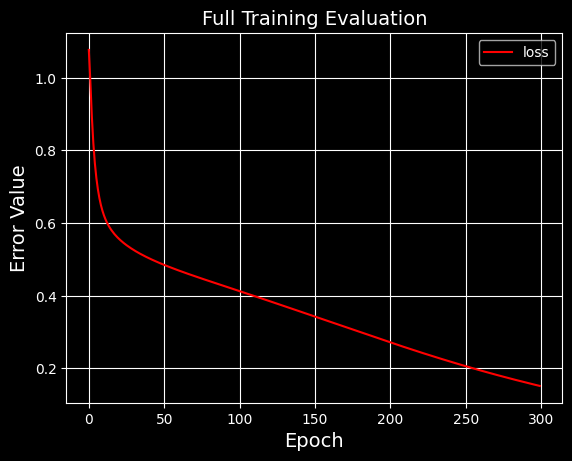

In [12]:
plt.plot(losses_3, label='loss', color='red')
plt.title('Full Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**G. Testing the Network**

In [13]:
model_3 = BalancedNeuralNetwork(5000,3)
state = torch.load("./torch_models/model_3.pth")
model_3.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [14]:
y_test

tensor([1, 2, 2,  ..., 1, 2, 1])

Using the same `X_test_vec` and `y_test` we applied on `model_1`.

In [15]:
predictions_3 = model_3.forward(X_test_vec)
predictions_3 = torch.softmax(predictions_3, dim=1)
predictions_3 = torch.argmax(predictions_3, dim=1)
predictions_3

tensor([1, 2, 2,  ..., 1, 2, 1])

In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions_3)
accuracy

0.9448414695520886

In [17]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, predictions_3, average='macro')
recall

0.9536275604582508

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions_3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1550
           1       0.93      0.95      0.94      4451
           2       0.94      0.92      0.93      3934

    accuracy                           0.94      9935
   macro avg       0.96      0.95      0.95      9935
weighted avg       0.95      0.94      0.94      9935



Our `model_2` achieved considerably better results on the same test set we applied to `model_1`. Upsampling the `negative` class allowed the model to learn it better on par on how it learn other classes, which could be the reason for its high recall `(0.89)` and f1-score `(0.91)`. The thing is we have to tune our `Variational Autoencoder` model. Although not shown, tweaking it from `learning_rate = 0.001` to `learning_rate = 0.0001`, all others remaining constant, is the reason why we have achieved this results. 

(A `learning_rate = 0.001` on the Autoencoder produced much poorer results on `model_2`: recall=`0.34`, f1-score=`0.36`, accuracy=`0.42`)

#### **End. Thank you!**